Part1:
1.Optimizing the clean method & Using 5 fold cross validation rather than train_test_split to make the output more stable and reliable

In [269]:
import pandas as pd
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

#initializing a sample df
df = pd.read_csv("/Users/yangshuming/Downloads/dataset.tsv", sep="\t")
print(df.shape)          
print(df["topic"].value_counts())
print(df.head())

#create a new colunm which gathers 'artist_name, track_name, genre and lyrics' after filling Nan value into column 'doc' for table df.
df["doc"] = (
    df["artist_name"].fillna("") + " "
    + df["track_name"].fillna("") + " "
    + df["genre"].fillna("") + " "
    + df["lyrics"].fillna("")
)

import re, nltk, string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)
stemmer = PorterStemmer()
stop    = set(nltk.corpus.stopwords.words("english"))

#cleaning the dataset
def clean(text):
    # Keep apostrophes inside words (e.g. **rock'n'roll**)
    text = re.sub(r"[^\w\s'’\-]", " ", text)      # remove every symbol except letters, numbers & apostrophes
    text = text.lower()
    tokens = [stemmer.stem(t) for t in text.split() if t not in stop]
    return " ".join(tokens)


X_clean = df["doc"].apply(clean).values          
y = df["topic"].values

# Imports you still need
from sklearn.pipeline import make_pipeline              # <- this line is missing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, StratifiedKFold

# Vectorisers (tweak max_features to your chosen N)
vectoriser_binary  = CountVectorizer(binary=True,  max_features=10000)
vectoriser_counts  = CountVectorizer(binary=False, max_features=10000)
vectoriser_tfidf   = TfidfVectorizer(sublinear_tf=True, max_features=10000)

# using Stratified 5-fold object rather than train_test_split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

# The pipelines dictionary
pipelines = {
    "BNB":    make_pipeline(vectoriser_binary, BernoulliNB()),
    "MNB":    make_pipeline(vectoriser_counts, MultinomialNB(alpha=1.0)),
    "LogReg": make_pipeline(vectoriser_tfidf, LogisticRegression(max_iter=500))
}
# Evaluate
import numpy as np
for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_clean, y, cv=cv, scoring=scoring)
    print(f"{name:6s}  F1-macro = {scores['test_f1_macro'].mean():.3f}")


(1500, 6)
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64
                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  awake know go see time clear world mirror worl...       dark  
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle  
2  blues  lose deep catch breath think say try break wal...    sadness  
3  blues  run bitter taste take rest feel anchor soul pl...    sadness  
4  blues  think think different set apart sober min

/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

BNB     F1-macro = 0.354
MNB     F1-macro = 0.737


/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

LogReg  F1-macro = 0.625


2.Temprarily producing the corresponding clean function to get X_cleaner for all the set of preprocessing. Then using the same StratifiedKFold to get the score of each set. Recording all the output to df_res. Picking up the best set which gets the heighest score. Writhing the arguments of the set into BEST_PREPROC for the following step.

In [270]:
import itertools, re, nltk, pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download("wordnet")    
nltk.download("omw-1.4")     


# options of preprocessing
stem_opts   = {"none": None, "porter": PorterStemmer(), "lemma": WordNetLemmatizer()}
lower_opts  = [True, False]
stop_lists  = {"none": None,
               "nltk":  set(stopwords.words("english")),
               "sklearn": "english"}                 
keep_apos   = [True, False]
keep_hyphen = [True, False]

# clean function
def make_cleaner(lower, stop_set, stemmer, keep_ap, keep_hy):
    regex = r"[^\w\s" + ("'’" if keep_ap else "") + (r"\-" if keep_hy else "") + "]"
    stop  = stop_set if isinstance(stop_set, set) else set()
    def _clean(text):
        txt = re.sub(regex, " ", text)
        if lower: txt = txt.lower()
        toks = txt.split()
        if stop: toks = [t for t in toks if t not in stop]
        if stemmer: toks = [stemmer.stem(t) if hasattr(stemmer, "stem")
                            else stemmer.lemmatize(t) for t in toks]
        return " ".join(toks)
    return _clean

# setting cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
grid_iter = itertools.product(lower_opts, stop_lists.items(),
                              stem_opts.items(), keep_apos, keep_hyphen)

for lower, (stop_name, stop_set), (stem_name, stemmer), ap, hy in grid_iter:
    cleaner   = make_cleaner(lower, stop_set, stemmer, ap, hy)
    X_cleaner = df["doc"].apply(cleaner).values

    for model_name, model in [("BNB", BernoulliNB()), ("MNB", MultinomialNB())]:
        vec = CountVectorizer(binary=(model_name=="BNB"),
                              max_features=10000,    
                              stop_words=(stop_set if isinstance(stop_set,str) else None))
        pipe = make_pipeline(vec, model)
        f1 = cross_val_score(pipe, X_cleaner, y,
                             cv=cv, scoring="f1_macro").mean()
        results.append({
            "model": model_name, "lower": lower, "stop": stop_name,
            "stem": stem_name, "keep_'": ap, "keep-": hy, "macro_F1": round(f1,3)
        })

# evaluation
df_res = pd.DataFrame(results).sort_values("macro_F1", ascending=False)
display(df_res.head(5)) 
# displaying the top3 of each model
top_each = df_res.groupby("model").head(3)
display(top_each)


# choose the set that gets the highest score, then using this set following
best = df_res.iloc[0]
BEST_PREPROC = best.to_dict()
print("Chosen BEST_PREPROC →", BEST_PREPROC)

# define clean_best function based on BEST_PREPROC
def build_cleaner_from_cfg(cfg):
    lower     = cfg["lower"]
    stop_set  = stop_lists[cfg["stop"]]
    stemmer   = stem_opts[cfg["stem"]]
    keep_ap   = cfg["keep_'"]
    keep_hy   = cfg["keep-"]
    return make_cleaner(lower, stop_set, stemmer, keep_ap, keep_hy)

clean_best = build_cleaner_from_cfg(BEST_PREPROC)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yangshuming/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yangshuming/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,model,lower,stop,stem,keep_',keep-,macro_F1
115,MNB,False,nltk,lemma,True,False,0.737
35,MNB,True,nltk,porter,True,False,0.737
107,MNB,False,nltk,porter,True,False,0.737
33,MNB,True,nltk,porter,True,True,0.737
105,MNB,False,nltk,porter,True,True,0.737


,model,lower,stop,stem,keep_',keep-,macro_F1
115,MNB,False,nltk,lemma,True,False,0.737
35,MNB,True,nltk,porter,True,False,0.737
107,MNB,False,nltk,porter,True,False,0.737
12,BNB,True,none,porter,False,True,0.356
14,BNB,True,none,porter,False,False,0.356
84,BNB,False,none,porter,False,True,0.356


Chosen BEST_PREPROC → {'model': 'MNB', 'lower': False, 'stop': 'nltk', 'stem': 'lemma', "keep_'": True, 'keep-': False, 'macro_F1': 0.737}


3.Transforming text into matrix, then evaluate each metrics for model BNB & MNB. The dataset, which rate of each type is 490 : 376 : 347 : 205 : 82, is imbalanced. So choosing Macro-F1 as the primary metric and accuracy as the secondary metric to evaluate the models. As the result, MNB is the better model for classification. MNB plus the best preprocessing will be used as the default classifier.

In [271]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import pandas as pd, matplotlib.pyplot as plt

X = df["doc"].apply(clean_best).values      
y = df["topic"].values

# ② vectorizer + model
vec_B   = CountVectorizer(binary=True,  max_features=10000)
vec_M   = CountVectorizer(binary=False, max_features=10000)   

pipe_BNB = make_pipeline(vec_B, BernoulliNB())
pipe_MNB = make_pipeline(vec_M, MultinomialNB())

# ③ 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc":"accuracy",
           "bal_acc":"balanced_accuracy",
           "macroF1":"f1_macro",
           "wF1":"f1_weighted",
           "macroRec"   : "recall_macro",
           "macroPrec"  : "precision_macro",}

res = {}
for name, pipe in {"BNB":pipe_BNB, "MNB":pipe_MNB}.items():
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    res[name] = {m: scores[f"test_{m}"].mean() for m in scoring}

df_cmp = pd.DataFrame(res).T.round(3)
display(df_cmp)            


/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

,acc,bal_acc,macroF1,wF1,macroRec,macroPrec
BNB,0.542,0.392,0.350,0.478,0.392,0.475
MNB,0.802,0.711,0.737,0.795,0.711,0.824


4.setting several N, 100 200 300 400 500 750 and 1000, to measure which is the best N. As we can see the result, the Macro-F1 rises first then drop. So comparing all the N's, 400 is the best N for the most frequent words in the Vectorizer

,N,BNB_macroF1,MNB_macroF1
0,100,0.451,0.726
1,200,0.513,0.824
2,300,0.547,0.845
3,400,0.562,0.853
4,500,0.556,0.856
5,750,0.542,0.852
6,1000,0.529,0.836


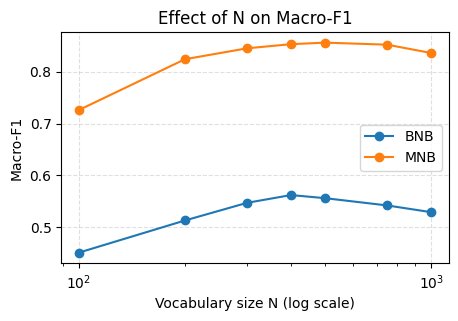

In [272]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# cleaning data
X_best = df["doc"].apply(clean_best).values
y      = df["topic"].values

# setting N's
N_list = [100, 200, 300, 400, 500, 750, 1000]

# cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for N in N_list:
    # BNB: binary feature
    vec_B = CountVectorizer(binary=True,  max_features=N)
    f1_B  = cross_val_score(make_pipeline(vec_B, BernoulliNB()),
                            X_best, y, cv=cv, scoring="f1_macro").mean()
    # MNB: frequency feature
    vec_M = CountVectorizer(binary=False, max_features=N)
    f1_M  = cross_val_score(make_pipeline(vec_M, MultinomialNB()),
                            X_best, y, cv=cv, scoring="f1_macro").mean()
    rows.append((N, round(f1_B,3), round(f1_M,3)))

df_N = pd.DataFrame(rows, columns=["N", "BNB_macroF1", "MNB_macroF1"])
display(df_N)

plt.figure(figsize=(5,3))
plt.plot(df_N["N"], df_N["BNB_macroF1"], marker="o", label="BNB")
plt.plot(df_N["N"], df_N["MNB_macroF1"], marker="o", label="MNB")
plt.xscale("log"); plt.xlabel("Vocabulary size N (log scale)")
plt.ylabel("Macro-F1"); plt.title("Effect of N on Macro-F1")
plt.legend(); plt.grid(True, ls="--", alpha=.4)
plt.show()


5.Another machine learning method that i use is linear SVM, which is a discriminative classifier. Different from the MNB and BNB, it maximizes the gap between classes, perfoming dominatively on Countvectorizer and tf-idf vector. For linear SVM i use here, preprocessing is same used for BNB and MNB, and N, which is 400, the best for MNB and BNB, is used for linear SVM as well. In additioin, i tune another hyperparameter C. i choose three value of C, for example 0.01, 0,1 and 1. Using GridSearch to select the best result of each C, then return the C.

In [273]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

# text → tf-idf features
vec   = CountVectorizer(max_features=400,  
                        stop_words=None, binary=False)
tfidf = TfidfTransformer(sublinear_tf=True)

# Linear SVM classifier
svm   = LinearSVC(class_weight="balanced", dual=False)  

pipe_svm = make_pipeline(vec, tfidf, svm)

# testing the best C
param_grid = {"linearsvc__C": [0.01, 0.1, 1]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_svm, param_grid,
                    scoring="f1_macro", cv=cv, n_jobs=-1)
grid.fit(df["doc"].apply(clean_best).values, y)

print("the best C =", grid.best_params_["linearsvc__C"])
print("5-fold Macro-F1 =", round(grid.best_score_, 3))

svm_best = grid.best_estimator_ 
scoring = {"acc":"accuracy",
           "bal_acc":"balanced_accuracy",
           "macroF1":"f1_macro",
           "wF1":"f1_weighted",
           "macroRec"   : "recall_macro",
           "macroPrec"  : "precision_macro",}

models = {
    "BNB" : pipe_BNB,
    "MNB" : pipe_MNB,
    "SVM" : svm_best, # uing the best C of SVM
}

records = []
for name, est in models.items():
    scores = cross_validate(est, X_best, y, cv=cv,
                            scoring=scoring, n_jobs=-1)
    records.append({
        k: scores[f"test_{k}"].mean() for k in scoring
    } | {"Model": name})

df_cmp = (pd.DataFrame(records)
            .set_index("Model")
            .round(3)
            .sort_values("macroF1", ascending=False))
display(df_cmp)



the best C = 0.1
5-fold Macro-F1 = 0.791


/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/rs9727/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

,acc,bal_acc,macroF1,wF1,macroRec,macroPrec
Model,,,,,,
SVM,0.829,0.791,0.791,0.829,0.791,0.795
MNB,0.802,0.711,0.737,0.795,0.711,0.824
BNB,0.542,0.392,0.350,0.478,0.392,0.475


Part2:
1.Deviding the first 1000 data into training data and test data, first 750 of 1000 are training data and last 250 of 1000 are test data. predicting the topic for all the 1500 songs, training data and test data.

In [274]:
# split the dataset. The first 750 rows are splited to train data and data from 750 to 1000 row are classified to test data
train_df = df.iloc[:750].reset_index(drop=True)    
test_df  = df.iloc[750:1000].reset_index(drop=True)

X_clean_train = train_df["doc"].apply(clean_best).values
y_train       = train_df["topic"].values

# training the model
best_clf = svm_best                      
best_clf.fit(X_clean_train, y_train)         

# getting the label of each songs
df["pred_topic"] = best_clf.predict(df["doc"].apply(clean_best))

train_df["pred_topic"] = df.loc[:749,  "pred_topic"].values
test_df ["pred_topic"] = df.loc[750:999, "pred_topic"].values

print("the predicted label of all songs:\n",df["pred_topic"], sep="")
print("the predicted label of training data:\n", train_df["pred_topic"], sep="")
print("the predicted label of test data:\n", test_df["pred_topic"], sep="")


the predicted label of all songs:
0            dark
1       lifestyle
2         sadness
3         sadness
4            dark
          ...    
1495      emotion
1496         dark
1497         dark
1498     personal
1499      sadness
Name: pred_topic, Length: 1500, dtype: object
the predicted label of training data:
0           dark
1      lifestyle
2        sadness
3        sadness
4           dark
         ...    
745     personal
746    lifestyle
747    lifestyle
748      sadness
749         dark
Name: pred_topic, Length: 750, dtype: object
the predicted label of test data:
0       sadness
1      personal
2          dark
3          dark
4          dark
         ...   
245     sadness
246    personal
247     sadness
248        dark
249        dark
Name: pred_topic, Length: 250, dtype: object


Collecting text for each topics, and fitting vectorizer

In [275]:
# gurantee that every data has its correct topic
topics = ["dark", "emotion", "lifestyle", "personal", "sadness"]

# producing fitVector for every topics. Each topic has its own vector
from sklearn.feature_extraction.text import TfidfVectorizer

N = 400                     
topic_vecs  = {}            # {'dark': vectorizer, ...}
song_tfidf  = {}            # {'dark': matrix (n_doc × N), ...}

for t in topics:
    # extracting all the lyrics from training data of the topic
    docs_t = train_df.loc[train_df["pred_topic"] == t, "doc"].apply(clean_best).tolist()
    if not docs_t:            
        continue
    
    # vectorizer
    vec = TfidfVectorizer(max_features=N, sublinear_tf=True)
    X_t = vec.fit_transform(docs_t)      
    
    topic_vecs[t] = vec
    song_tfidf[t] = X_t

    print(f"{t:<9s}  songs={X_t.shape[0]:3d}  vocab={len(vec.vocabulary_):4d}")



dark       songs=243  vocab= 400
emotion    songs= 45  vocab= 400
lifestyle  songs= 96  vocab= 400
personal   songs=185  vocab= 400
sadness    songs=181  vocab= 400


Users liking the songs, matching the keywords of each users with the lyrics of songs to demonstrate the user like which topic songs. Reading to users profiles, user1 and user2, and creating a new user3 given topics and keywords. Searching the training dataset and fufilling the likes list.

In [276]:
import pandas as pd, re

# reading the keywords of user1 and user2.
def load_user_keywords(tsv_path):
    
    d = {}
    for line in open(tsv_path, encoding="utf-8"):
        topic, kw_str = line.strip().split("\t")
        kws = [k.strip().lower() for k in kw_str.split(",") if k.strip()]
        d[topic] = kws
    return d

user_kw = {
    "user1": load_user_keywords("/Users/yangshuming/Downloads/user1.tsv"),
    "user2": load_user_keywords("/Users/yangshuming/Downloads/user2.tsv"),
}

# defining a user3 with topics and keywords
user_kw["user3"] = {
    "dark"     : ["night", "shadow", "death"],
    "lifestyle": ["party", "dance", "money"],
    "personal" : ["family", "home"]
    
}

# users liking songs

train_df = df.iloc[:750]

# initializing：{user: {topic: [doc, doc, ...]}}
user_likes = {u:{t:[] for t in topics} for u in user_kw.keys()}

pattern = re.compile(r"[a-z']+")   

def liked(lyric, kw_list):
    if not kw_list:
        return False
    words = set(pattern.findall(lyric.lower()))
    return any(k in words for k in kw_list)


for _, row in train_df.iterrows():
    topic_pred  = row["pred_topic"].lower()
    lyric_lower = row["lyrics"].lower()

    for usr, kw_dict in user_kw.items():
        if liked(lyric_lower, kw_dict.get(topic_pred, [])):
            user_likes[usr][topic_pred].append(lyric_lower)

# print the liked songs for each users
for usr in user_likes:
    print(f"\n{usr} liked songs per topic:")
    for t in topics:
        print(f"  {t:<9s}: {len(user_likes[usr][t])}")





user1 liked songs per topic:
  dark     : 64
  emotion  : 26
  lifestyle: 35
  personal : 118
  sadness  : 10

user2 liked songs per topic:
  dark     : 0
  emotion  : 13
  lifestyle: 0
  personal : 0
  sadness  : 17

user3 liked songs per topic:
  dark     : 52
  emotion  : 0
  lifestyle: 18
  personal : 33
  sadness  : 0


Integrating user_likes and topic_vecs to generate tf-idf vector of each users in every topics. TfidfVectorizer (vec) transforming text into tf-idf vector to get user profile user_profiles[user][t]. Getting top-20 words by using arr.argsort().

Comment: Some words seem not reasonable. for example, the top-20 existing words of user1 for the dark topic have 'oouuu, platform, whoaohoh...', which don't represent dark.

In [277]:
from collections import defaultdict
import numpy as np

user_profiles = defaultdict(dict)      

for user, likes_by_topic in user_likes.items():
    print(f"\n=====  {user.upper()}  =====")
    for t in topics:
        docs = likes_by_topic[t]
        if not docs:                          
            print(f"{t:<9s}: <no liked songs>")
            continue
        
        # merging all the lyrics of liked songs into one text 
        big_doc = " ".join(docs)
        
        # reflecting to the tf-idf vector space of the topic 
        vec = topic_vecs[t]
        tfidf_vec = vec.transform([clean_best(big_doc)])   
        user_profiles[user][t] = tfidf_vec                 
        
        # getting top-20 words
        arr = tfidf_vec.toarray().ravel()
        top_idx = arr.argsort()[-20:][::-1]                
        terms   = vec.get_feature_names_out()[top_idx]
        weights = arr[top_idx]
        
    
        term_list = ", ".join(f"{w}({s:.2f})" for w, s in zip(terms, weights))
        print(f"{t:<9s}: {term_list}")



=====  USER1  =====
dark     : dilly(0.11), lanky(0.11), oouuu(0.10), gladiator(0.10), platform(0.09), slave(0.09), whoaohoh(0.09), statue(0.09), harder(0.08), slow(0.08), papa(0.08), silent(0.08), murder(0.08), riot(0.08), brother(0.08), sword(0.08), story(0.08), cry(0.07), battle(0.07), follow(0.07)
emotion  : video(0.12), loove(0.12), vibe(0.12), touch(0.11), sunrise(0.11), gimme(0.11), vision(0.11), feelin(0.11), luck(0.10), lovin(0.10), human(0.10), morning(0.10), traffic(0.10), miss(0.09), doin(0.09), addiction(0.09), week(0.09), soft(0.09), body(0.09), coast(0.09)
lifestyle: spoil(0.12), closer(0.12), lalala(0.11), telephone(0.11), ring(0.11), oohoohooh(0.11), depression(0.11), snake(0.10), tire(0.10), bada(0.10), charmer(0.10), backroad(0.09), ready(0.09), woah(0.09), unconditional(0.09), dear(0.09), thought(0.09), moooooove(0.09), celebrate(0.09), boom(0.09)
personal : ordinary(0.10), shout(0.09), oohoohoohooh(0.09), automaton(0.09), crayon(0.08), habit(0.08), vibe(0.07), nec

2.Selecting N=25 for the recommendation list, then generating the recommondation list according to the cosine similarity, higher score representing user likes the song more possibly.

In [278]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

N_RECOMMEND = 25                               
users       = ["user1", "user2", "user3"]      
topics      = ["dark", "emotion", "lifestyle", "personal", "sadness"]


test_df = df.iloc[750:1000].copy().reset_index()   
test_df.rename(columns={"index": "row_id"}, inplace=True)

# generating tf-idf vector of Week-4 songs for each topics
song_tfidf_test = {}       
song_meta_test  = {}       

for t in topics:
    mask = test_df["pred_topic"] == t           
    docs = test_df.loc[mask, "doc"].apply(clean_best).tolist()
    if not docs:                                
        continue
    vec = topic_vecs[t]                        
    X   = vec.transform(docs)                   
    song_tfidf_test[t] = X
    song_meta_test[t] = test_df.loc[mask, ["row_id", "artist_name", "track_name"]]\
                                      .reset_index(drop=True)

print({k: m.shape for k, m in song_tfidf_test.items()})



# calculating the score of all the songs of week-4 for every users
recomm_all = {}          

for u in users:
    rows = []            
    
    for t in topics:
        
        user_vec = user_profiles[u].get(t)
        if user_vec is None or user_vec.nnz == 0:
            continue
        
        song_mat = song_tfidf_test.get(t)
        if song_mat is None or song_mat.shape[0] == 0:
            continue
        
        # calculating the cosine similarity
        sims = cosine_similarity(song_mat, user_vec).ravel()
        
        meta_df = song_meta_test[t].copy()
        meta_df["topic"] = t
        meta_df["score"] = sims
        rows.append(meta_df)
    

    if rows:
        full_df = pd.concat(rows, ignore_index=True)
        recomm_all[u] = full_df.sort_values("score", ascending=False)\
                               .head(N_RECOMMEND)\
                               .reset_index(drop=True)
    else:
        recomm_all[u] = pd.DataFrame()   


for u, rec in recomm_all.items():
    print(f"\n=====  Top-{N_RECOMMEND} for {u}  =====")
    if rec.empty:
        print(" <no recommendation>")
    else:
        display(rec[["row_id", "topic", "artist_name", "track_name", "score"]].head(10))  


{'dark': (70, 400), 'emotion': (19, 400), 'lifestyle': (29, 400), 'personal': (58, 400), 'sadness': (74, 400)}

=====  Top-25 for user1  =====


,row_id,topic,artist_name,track_name,score
0,881,dark,alec benjamin,boy in the bubble,0.340272
1,792,dark,deca,donner bell,0.338837
2,789,sadness,anita baker,will you be mine,0.332036
3,992,emotion,taylor swift,i did something bad,0.316069
4,884,personal,alborosie,rocky road,0.311450
5,901,dark,hunter hayes,still,0.303940
6,855,dark,the dear hunter,the flame (is gone),0.300484
7,795,lifestyle,wallows,it's only right,0.299917
8,926,personal,the band steele,sit awhile,0.294589
9,897,personal,playboi carti,love hurts (feat. travis scott),0.293744



=====  Top-25 for user2  =====


,row_id,topic,artist_name,track_name,score
0,802,sadness,skip marley,cry to me,0.311086
1,943,sadness,naomi scott,speechless (full),0.293870
2,865,sadness,lil wayne,scared of the dark (feat. xxxtentacion),0.271859
3,766,sadness,kygo,remind me to forget,0.270693
4,818,sadness,311,hey yo,0.262529
5,899,emotion,parker millsap,hands up,0.260328
6,868,sadness,soja,i can't stop dreaming,0.259380
7,789,sadness,anita baker,will you be mine,0.256330
8,791,sadness,hellyeah,love falls,0.246589
9,952,sadness,jonas brothers,don't throw it away,0.246517



=====  Top-25 for user3  =====


,row_id,topic,artist_name,track_name,score
0,884,personal,alborosie,rocky road,0.339611
1,926,personal,the band steele,sit awhile,0.328652
2,792,dark,deca,donner bell,0.322562
3,901,dark,hunter hayes,still,0.321354
4,944,personal,timeflies,once in a while,0.312705
5,797,personal,billie eilish,bored,0.312659
6,984,dark,busta rhymes,why we die (feat. dmx and jay z),0.305355
7,881,dark,alec benjamin,boy in the bubble,0.305321
8,765,personal,iya terra,follow your heart (feat. zion thompson from th...,0.297358
9,923,personal,soja,everything to me,0.290564


producing the truth label, using the pattern of keywords + predicted topics to discriminate the song is liked, while the keywords matching the lyrics of the song, or disliked, and put the result in truth_df, which is a table including all the songs from week-4 liked or disliked by each users. Then defining an estimation function merging the recommadation result and truth_df to calculate Precision/Recall/F1@N.

In [279]:
records = []

for user in users:
    for _, row in test_df.iterrows():          
        pred_t   = row["pred_topic"]
        kw_list  = user_kw[user].get(pred_t, [])   
        liked    = int(is_liked(row["lyrics"], kw_list))

        records.append({
            "row_id": row["row_id"],   
            "user"  : user,
            "liked" : liked
        })

truth_df = pd.DataFrame(records)
tdf = truth_df.groupby("user")["liked"].sum()
print(tdf)

def metrics_at_N(recommend_df, truth_subset, N=25):
    
    merged = (recommend_df[["row_id"]]               
                .merge(truth_subset, on="row_id", how="left")
                .fillna({"liked":0}))
    hit      = int(merged["liked"].sum())            
    precision= hit / N
    total_like = int(truth_subset["liked"].sum())
    recall   = hit / total_like if total_like else 0
    f1       = 0 if precision+recall==0 else 2*precision*recall/(precision+recall)
    return precision, recall, f1

rows = []
for u in users:
    p,r,f1 = metrics_at_N(recomm_all[u], truth_df[truth_df["user"]==u])
    rows.append({"user":u, "P@25":round(p,3),
                          "R@25":round(r,3),
                          "F1@25":round(f1,3)})
print(pd.DataFrame(rows))



user
user1    83
user2    11
user3    31
Name: liked, dtype: int64
    user  P@25   R@25  F1@25
0  user1  0.64  0.193  0.296
1  user2  0.24  0.545  0.333
2  user3  0.44  0.355  0.393


Comparing hyperparameters. We have argument M, the number of words in the user profile for each topic, matching algorithm, cosine similarity and dot, and fixed N. As the result shows below, M = 50, which means each topic remains top 50 words, with cosine similarity gets the highest average F1@25 which equals to 0.371 . In addition, the combination of M=50 with cosine similarity keeps other metrics in an appropriate scale, so choosing it as the default matching strategy.

In [280]:
import numpy as np, pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import re



def truncate_vec(vec, topM: int | None):
    if topM is None:          
        return vec
    if vec.nnz == 0:          
        return vec
    
    arr = vec.toarray().ravel()
    if vec.nnz <= topM:
        return vec
    # getting index of topM which have the higher weight
    top_idx = arr.argsort()[-topM:]
    mask = np.zeros_like(arr); mask[top_idx] = 1
    arr = arr * mask          
    return csr_matrix(arr)    

# dot score
def dot_score(song_mat, user_vec):
    return (song_mat @ user_vec.T).toarray().ravel()      


def metrics_at_N(recommend_df, truth_subset, N):
    merged = (recommend_df[["row_id"]]
                .merge(truth_subset, on="row_id", how="left")
                .fillna({"liked":0}))
    hit = merged["liked"].sum()
    precision = hit / N
    total_like = truth_subset["liked"].sum()
    recall = hit / total_like if total_like else 0
    f1 = 0 if precision+recall==0 else 2*precision*recall/(precision+recall)
    return precision, recall, f1


# parameter grid
max_nnz = max(vec.nnz for u in user_profiles.values() for vec in u.values())
# testing different M to illustrate which value of M has the best output
M_options = {f"{m:03d}": m for m in range(10, max_nnz + 1, 10)}
M_options["All"] = None     
matchers    = {"cosine": cosine_similarity, "dot": dot_score}
N_RECOMMEND = 25

rows = []

for M_name, topM in M_options.items():
    
    user_prof_M = {}
    for u in users:
        d = {}
        for t, vec in user_profiles[u].items():
            d[t] = truncate_vec(vec, topM)
        user_prof_M[u] = d
    
    for matcher_name, scorer in matchers.items():
        # generating recommendation list
        recomm_all_tmp = {}
        for u in users:
            basket = []
            for t in topics:
                u_vec = user_prof_M[u].get(t)
                S_mat = song_tfidf_test.get(t)
                if u_vec is None or u_vec.nnz == 0 or S_mat is None:
                    continue
                sims = (scorer(S_mat, u_vec).ravel()
                        if matcher_name=="cosine"
                        else dot_score(S_mat, u_vec))
                tmp = song_meta_test[t].copy()
                tmp["score"] = sims; tmp["topic"]=t
                basket.append(tmp)
            if basket:
                df_top = (pd.concat(basket, ignore_index=True)
                            .sort_values("score", ascending=False)
                            .head(N_RECOMMEND))
                recomm_all_tmp[u] = df_top
            else:
                recomm_all_tmp[u] = pd.DataFrame()
        
        # evaluating
        for u in users:
            P,R,F1 = metrics_at_N(recomm_all_tmp[u],
                                  truth_df[truth_df["user"]==u],
                                  N_RECOMMEND)
            rows.append({"user":u, "M":M_name, "matcher":matcher_name,
                         "P@25":round(P,3), "R@25":round(R,3), "F1@25":round(F1,3)})

df_cmp = (pd.DataFrame(rows)
            .set_index(["M","matcher","user"])
            .unstack("user")               
            .round(3))

display(df_cmp)

f1_cols = df_cmp['F1@25']          
# calculating the average of F1
df_cmp = df_cmp.copy()          
df_cmp['macroF1'] = f1_cols.mean(axis=1)
# macroF1 descend
print(df_cmp['macroF1'].sort_values(ascending=False))


P@25               R@25                F1@25              
user        user1 user2 user3  user1  user2  user3  user1  user2  user3
M   matcher                                                            
010 cosine   0.40  0.32  0.28  0.120  0.727  0.226  0.185  0.444  0.250
    dot      0.32  0.32  0.28  0.096  0.727  0.226  0.148  0.444  0.250
020 cosine   0.32  0.20  0.44  0.096  0.455  0.355  0.148  0.278  0.393
    dot      0.28  0.20  0.40  0.084  0.455  0.323  0.130  0.278  0.357
030 cosine   0.32  0.24  0.36  0.096  0.545  0.290  0.148  0.333  0.321
...           ...   ...   ...    ...    ...    ...    ...    ...    ...
370 dot      0.64  0.24  0.44  0.193  0.545  0.355  0.296  0.333  0.393
380 cosine   0.64  0.24  0.44  0.193  0.545  0.355  0.296  0.333  0.393
    dot      0.64  0.24  0.44  0.193  0.545  0.355  0.296  0.333  0.393
All cosine   0.64  0.24  0.44  0.193  0.545  0.355  0.296  0.333  0.393
    dot      0.64  0.24  0.44  0.193  0.545  0.355  0.296  0.333  0.393

[78 rows x 9 columns]

M    matcher
050  cosine     0.370667
310  dot        0.352667
300  dot        0.346667
All  dot        0.340667
360  dot        0.340667
                  ...   
100  dot        0.254667
170  dot        0.254667
140  dot        0.254333
110  dot        0.248333
160  dot        0.236667
Name: macroF1, Length: 78, dtype: float64


Part3: for week1, 2 and 3, randomly selecting 25 songs of each week to the user, then let they mark "y" representing like the song.

In [281]:
import random
from pathlib import Path

N = 25                                              
random.seed(42)                                     

df = df.copy()                 
df["row_id"] = df.index        

# Week1-3
week_ranges = {"Week1": (0, 250), "Week2": (250, 500), "Week3": (500, 750)}

out_dir = Path("user_study_batches"); out_dir.mkdir(exist_ok=True)

batch_info = {}                                    
def export_batch_with_like(df_batch: pd.DataFrame, path: str):
    out = df_batch.copy()
    out["Like"] = ""           
    out.to_csv(path, index=False, encoding="utf-8-sig")
    print(f"file saved：{path}")

for wk, (start, end) in week_ranges.items():
    batch_df = (df.iloc[start:end]
                  .sample(N, random_state=start)
                  [["row_id","artist_name","track_name"]])
    export_batch_with_like(batch_df, out_dir / f"{wk}.csv")




file saved：user_study_batches/Week1.csv
file saved：user_study_batches/Week2.csv
file saved：user_study_batches/Week3.csv


reading the three files of three weeks songs marked like. priting the total count of liked songs.

In [285]:
def read_likes(csv_path):
    tbl = pd.read_csv(csv_path)
    liked_idx = tbl.loc[tbl["Like"].astype(str).str.upper().str.startswith("Y"), "row_id"]
    return liked_idx.tolist()

likes_idx = []
for wk in week_ranges:
    likes_idx.extend(read_likes(out_dir / f"/Users/yangshuming/user_study_batches/{wk}.csv"))

print(f"the user likes {len(likes_idx)} songs")


global_tfidf = TfidfVectorizer(sublinear_tf=True, max_features=400)
global_tfidf.fit(df["doc"].apply(clean_best))
def build_profile_from_idx(idx_list):
    lyrics_concat = " ".join(df.loc[idx_list, "lyrics"].apply(clean_best))
    vec   = global_tfidf  
    tfidf = vec.transform([lyrics_concat])
    return truncate_vec(tfidf, 50)                  

user_profile_real = build_profile_from_idx(likes_idx)


the user likes 27 songs


recommanding songs from week4 to user, based on the songs that user likes from training data week1-3. and let user mark the songs that they like.

In [286]:
week4_df = df.iloc[750:1000].copy().reset_index()      
X_week4   = global_tfidf.transform(week4_df["doc"].apply(clean_best))
week4_meta = week4_df[["row_id","artist_name","track_name"]]

def recommend_week4(profile_vec, topN=25):
    sim = cosine_similarity(X_week4, profile_vec).ravel()
    return (week4_meta.assign(score=sim)          
                     .sort_values("score", ascending=False)
                     .head(topN)
                     .reset_index(drop=True))

N = 25
recs = recommend_week4(user_profile_real, N)
recs["Like"] = ""                                 
cols = ["row_id","artist_name","track_name","score","Like"]
recs.to_csv(out_dir / "Week4recommend.csv",
            columns=cols, index=False, encoding="utf-8-sig")

print(" Week-4 recommendation list saved as Week4recommend.csv")


 Week-4 recommendation list saved as Week4recommend.csv


read the file of Week4recommend, counting the songs are liked.

In [288]:
import pandas as pd

fb4 = pd.read_csv("/Users/yangshuming/user_study_batches/Week4recommend.csv")

liked_mask = (
    fb4["Like"]
      .astype(str)
      .str.strip()
      .str.lower()
      .str.startswith("y")
)

liked_count = liked_mask.sum()
print(f"user likes {liked_count} songs in 25 that are recommended。")


user likes 13 songs in 25 that are recommended。
